In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil 
import time
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                                  activation='relu', 
                                  input_shape=(128, 128, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(labels_dim, activation='sigmoid', kernel_initializer='glorot_uniform'))
    model.summary()
    compile_model(model)
    return model


def compile_model(model):
    opt = keras.optimizers.Adagrad(lr=0.01)
    ada = keras.optimizers.Adadelta()
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=ada,
                  metrics=['accuracy'])
    return model


def read_train_data():
    start_time = time.time()
    print("Start Read Train Data")
    data = np.load("trainDataSmall.npz")
    print("Train data read --- %s seconds ---" % (time.time() - start_time))
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    print("Training - Total examples per class", np.sum(Y_train, axis=0))
    return [X_train, Y_train]


def read_test_data():
    start_time = time.time()
    print("Start Read Test Data")
    data = np.load("testDataSmall.npz")
    print("Test data read --- %s seconds ---" % (time.time() - start_time))
    X_test = data["X_test"]
    Y_test = data["Y_test"]
    print("Testing - Total examples per class", np.sum(Y_test, axis=0))
    return [X_test, Y_test]


def get_latest(checkpoint_dir, filetype='.h5', signature='cp', overwrite=False):
    """ 
        This is a workaround as tf.train.latest_checkpoint does not seem to
        work well on codalab. Give preference to that function when possible.

        If overwrite is True, the latest checkpoint is reset to 0 and all 
        others are deleted.
    """
    latest = None
    latest_number = -1
    for filename in os.listdir(checkpoint_dir):
        reference, extension = os.path.splitext(filename)
        if extension == filetype and reference.startswith('cp'):
            number = int(re.sub(r"\D", "", reference))
            if number > latest_number:
                latest = filename
                latest_number = number
            else:
                if overwrite:
                    os.remove(os.path.join(checkpoint_dir, filename))
    if latest is None:
        raise ValueError('No previous checkpoint found.')
    if overwrite:
        os.rename(os.path.join(checkpoint_dir, latest), os.path.join(checkpoint_dir, 'cp-0000.h5'))
        latest = 'cp-0000.h5'
        shutil.rmtree(os.path.join(checkpoint_dir, 'logs')) 
    return os.path.join(checkpoint_dir, latest)


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_fn(5), show_shapes=True, show_layer_names=True)

In [ ]:
#CLASS_SIZE = 2
FILE_PATH = 'cp-{epoch:04d}.h5'
RETINOPATHY_MODEL = 'retinopathy.h5'


def run(num_epochs=20,  # Maximum number of epochs on which to train
        train_batch_size=40,  # Batch size for training steps
        job_dir='jobdir', # Local dir to write checkpoints and export model
        checkpoint_epochs='epoch',  #  Save checkpoint every epoch
        load_previous_model=False,
        CLASS_SIZE = 2):
  
    """ This function trains the model for a number of epochs and returns the 
        training history. The model is periodically saved for later use.

        You can load a pre-trained model with 
            `model.load_weights(cp_path)`
        where `model` is a keras object (e.g. as returned by `model_fn`) and 
        `cp_path` is the path for the checkpoint you want to load.
        
        Setting load_previous_model to True will load the latest checkpoint in
        `job_dir` and continue training. That checkpoint is renamed cp-0000.h5,
        while all logs and other checkpoints are deleted. Use with care!
    
    """
    
    tf.keras.backend.clear_session()

    try:
        os.makedirs(job_dir)
    except:
        pass

    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    retinopathy_model = model_fn(CLASS_SIZE)
    if load_previous_model:
        # Load the previously saved weights
        latest = get_latest(job_dir, overwrite=True)
        retinopathy_model.load_weights(latest)

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        save_freq=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        update_freq='epoch',
        write_graph=True,
        embeddings_freq=0)

    callbacks = [checkpoint, tblog]

    #[X_train, Y_train] = read_train_data()
    #[X_test, Y_test] = read_test_data()

    # Data augmentation. Other operations are possible.
    # https://keras.io/api/preprocessing/image/#imagedatagenerator-class
    datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
        )

    history = retinopathy_model.fit(
              datagen.flow(X_train, y_train_binary, batch_size=train_batch_size, seed=4),
              steps_per_epoch=100,
              epochs=num_epochs,
              callbacks=callbacks,
              verbose=2,
              validation_data=(X_test, np.array(y_test_binary)))
    
    predictions = retinopathy_model.predict(X_test)

    retinopathy_model.save(os.path.join(job_dir, RETINOPATHY_MODEL))

    return history, predictions


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive') ## If you want to read from your drive - this is not required, as you can get the files as below, but it might faster

## this will download the data from the internet, it may fail if the server is not up
![ -f testDataSmall.npz ] || wget -O testDataSmall.npz "https://www.win.tue.nl/~cdecampos/testDataSmall.npz"
![ -f trainDataSmall.npz ] || wget -O trainDataSmall.npz "https://www.win.tue.nl/~cdecampos/trainDataSmall.npz"

#history = run(load_previous_model=False, num_epochs=1)
#drive.flush_ad_unmount() ## if you need to unmount your google drive

--2020-12-06 12:12:49--  https://www.win.tue.nl/~cdecampos/testDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101034899 (96M) [text/plain]
Saving to: ‘testDataSmall.npz’

testDataSmall.npz   100%[===================>]  96.35M  10.8MB/s    in 23s     

2020-12-06 12:13:12 (4.28 MB/s) - ‘testDataSmall.npz’ saved [101034899/101034899]

--2020-12-06 12:13:12--  https://www.win.tue.nl/~cdecampos/trainDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203493642 (194M) [text/plain]
Saving to: ‘trainDataSmall.npz’

trainDataSmall.npz  100%[===================>] 194.07M  20.3MB/s    in 25s     

2020-12-06 12:13:38 (7.84 MB/s) - ‘trainDataSmall.npz’ saved [203493642/203493642]



In [ ]:
# Plot history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# Or visualise using Tensorboard
%tensorboard --logdir jobdir/logs

In [ ]:
[X_train, Y_train] = read_train_data()
[X_test, Y_test] = read_test_data()

Start Read Train Data
Train data read --- 0.00875544548034668 seconds ---
Training - Total examples per class [1000. 1000. 1000. 1000. 1000.]
Start Read Test Data
Test data read --- 0.0007033348083496094 seconds ---
Testing - Total examples per class [500. 500. 500. 500. 500.]


In [ ]:
Y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
def multiclass_to_binary(y_set):
  y_binary = []
  for classification in y_set:
    if str(classification[0]) == '1.0':
      y_binary.append([1, 0])
    else:
      y_binary.append([0, 1])
  return y_binary

def subclass_filt(binary_y_pred):
  index_filt = []
  for output in binary_y_pred:
    if output == [0, 1]:
      index.append(True)
    else:
      index.append(False)
  return index_filt


In [ ]:
y_train_binary = multiclass_to_binary(Y_train)
y_test_binary = multiclass_to_binary(Y_test)

In [ ]:
y_train_binary[0:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [ ]:
y_test_binary[0:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [ ]:
history, predictions = run(load_previous_model=False, num_epochs=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [ ]:
predictions[475:525]

array([[0.3308599 , 0.67237025],
       [0.27692047, 0.6993337 ],
       [0.41547394, 0.59401834],
       [0.32953298, 0.6617946 ],
       [0.3639989 , 0.64492136],
       [0.20971648, 0.7589087 ],
       [0.42289612, 0.574709  ],
       [0.4366861 , 0.5702213 ],
       [0.3015952 , 0.68491465],
       [0.36549813, 0.635975  ],
       [0.392877  , 0.6139424 ],
       [0.3007848 , 0.6968082 ],
       [0.38431257, 0.61018956],
       [0.36346713, 0.6274256 ],
       [0.29948923, 0.6685246 ],
       [0.36320853, 0.63058424],
       [0.38605657, 0.6052593 ],
       [0.4266527 , 0.56973785],
       [0.39664322, 0.5912345 ],
       [0.34053254, 0.6413818 ],
       [0.36983708, 0.63436896],
       [0.36164054, 0.6337882 ],
       [0.38063377, 0.6106463 ],
       [0.34445828, 0.6448272 ],
       [0.35787565, 0.64796853],
       [0.418727  , 0.58941454],
       [0.39923427, 0.58774555],
       [0.27427396, 0.72729206],
       [0.3189696 , 0.6647394 ],
       [0.333091  , 0.6592417 ],
       [0.

In [ ]:
len(y_test_binary)

2500

In [ ]:
count = 0
for x in predictions:
  if x[0] <= 0.5:
    count += 1

print(count)

2500


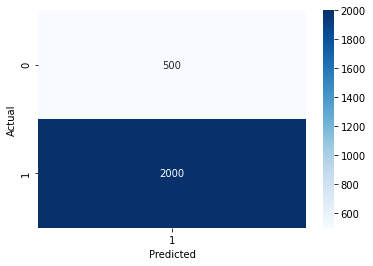

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#data = np.load("trainDataSmall.npz")
X_train = X_train
Y_train = y_train_binary

ret_model = keras.models.load_model(os.path.join('jobdir', RETINOPATHY_MODEL))
#[X_test, Y_test] = read_test_data()
predictions = ret_model.predict(X_test)

data = {'y_Actual':    np.array(y_test_binary).argmax(axis=1),
        'y_Predicted': [x[0] for x in predictions.argmax(axis=1).reshape(2500,1).tolist()]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
df.head()
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap="Blues")
plt.show()